In [1]:
%matplotlib inline
from IPython import display

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

import pickle

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
DEVICE_ID = 2
#device = torch.device('cuda:%d' % DEVICE_ID)
device = torch.device('cpu')
#torch.cuda.set_device(DEVICE_ID)
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cpu
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 150000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
class StateHolder:
    
    def __init__(self):
        self.screens = []
    
    def appendScreen(self, screen):
        if len(self.screens) < 4:
            self.screens.append(screen.squeeze(0))
        
        else:
            self.screens.pop(0)
            self.screens.append(screen.squeeze(0))

    def getState(self):
        return torch.stack(self.screens)

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'new_state'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.relu1  = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.relu2  = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.relu3  = nn.LeakyReLU()
        self.lin1   = nn.Linear(7 * 7 * 64, 512)
        self.lin2   = nn.Linear(512, 4)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.lin1(x.view(x.size(0), -1))
        x = self.lin2(x)
        return x

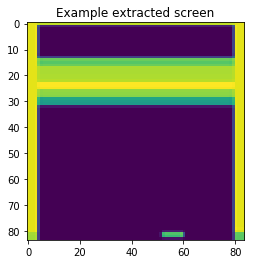

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

def get_screen(screen):
    resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])
    
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

env.reset()
plt.figure()
screen, _, _, _ = env.step(0)
plt.imshow(get_screen(screen).cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()



In [6]:
# Далее стандартный метод для выбора нового действия из лекции

with open('weights.pkl', "rb") as weights_file:
    policy_net = pickle.load(weights_file).to(device)
        
#policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=25*1e-5)

memory = ReplayMemory()
state_holder = StateHolder()

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

FileNotFoundError: [Errno 2] No such file or directory: 'weights.pkl'

In [ ]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.new_state)), device=device, dtype=torch.uint8)

    non_final_new_states = torch.stack([s for s in batch.new_state
                                                if s is not None])

    state_batch  = torch.stack(batch.state)
    action_batch = torch.stack(batch.action).squeeze(1).to(device)
    reward_batch = torch.stack(batch.reward).to(device)
    
    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch.float()).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    new_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    new_state_values[non_final_mask] = target_net(non_final_new_states.float()).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (new_state_values * GAMMA) + reward_batch.squeeze(1)

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()
    
    del non_final_mask
    del non_final_new_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del new_state_values
    del expected_state_action_values
    del loss

In [ ]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

#with open('weights1.pkl', "wb") as weights_file:
#                pickle.dump(policy_net, weights_file)
        
def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
        
steps_done = 0
policy_net.eval()
env.reset()

for _ in range(4):
        screen, _, _, _ = env.step(0)
        state_holder.appendScreen(get_screen(screen))

state = state_holder.getState()
total_reward = 0

done= False
while not done:
    # Выбрать и выполнить нове действие
    steps_done += 1
    rand = random.random()
        
    if rand > TEST_EPS:
        action = policy_net(state.unsqueeze(0).float()).max(1)[1].view(1, 1)
        
    else:
        action = torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)
    
    screen, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.appendScreen(get_screen(screen))
        state = state_holder.getState()
    else:
        break
    env.render()
    #show_state(env, steps_done)
    
print("Total game reward : {}".format(total_reward))